## Schrodinger Equation ##

We are going to solve the Schrodinger equation on a domain $\Omega_h$ with Dirichlet boundary contitions.

The equation to solve is:

$$
i \frac{\partial u}{\partial t} = \Delta u 
$$

Which we solve using,

$$
i (u - u_n) = dt *  \Delta (u + u_n)/2
$$

As time integrator, here $u = u_{n+1}$. Since the eigenvalues of $\Delta$ are proportional to $\Delta x^2$, $\lambda = -c/\Delta x^2$, $c > 0$, we must be carefull with the stability region of the method. We have, for each eigenfunction, 

$$
(i - \lambda dt/2)u = (i + \lambda dt /2 )u_n
$$

Thus, the amplification factor is: 

$$
|\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2}| = 1
$$

and the system is unconditionaly stable.



We shall use its weak form,

$$
\int [2i v*u +  \nabla v \cdot \nabla u ] \; d\Omega = \int [2i*v*u_n - \nabla v \cdot \nabla u_n ] \; d\Omega
$$



In [ ]:
#import Pkg; Pkg.activate("gridap_makie")
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
#using GridapGeosciences
using Gridap.Arrays
using Gridap.TensorValues
using Gridap.ReferenceFEs
using Gridap.Geometry
using Gridap.Fields
using Gridap.Algebra
using SparseArrays
using Gridap.FESpaces
using Gridap.CellData
using Gridap
using GridapMakie, GLMakie
using FileIO
#using gmsh
using LinearAlgebra
using SuiteSparse

  Activating project at `~/Docencia/PDE/pde_private/Tareas/Tarea_7/gridap_makie`


In [1]:
include("../../Tareas/Tarea_5/mesh_generator.jl")

grid_type = "double_slit"

Lx = 1.0
Ly = 1.0
Sx = 0.05
Sy = 0.4
SS = 0.05
#h = 0.01 #grosa not sure how it relates to h
#h = 0.1 #junta
h = 0.005 #
#p = ("double_slit_grosa", 1, 1, 0.05, 0.4, 0.05, h) #for test / rectangle (Length_x, Length_y, h) 
#p = ("double_slit_junta", 1, 1, 0.05, 0.3, 0.1, h)
#p = ("double_slit", 1, 1, 0.05, 0.25, 0.1, h)
p = ("double_slit_junta_dis", Lx, Ly, Sx, Sy, SS, h)
boundary_tags = ["ext","int"]
dirichlet_tags= ["ext","int"]
dirichlet_values = 0.0 # 0.0+im*0.0
model = make_model(grid_type, p)

LoadError: SystemError: opening file "/Users/reula/Docencia/PDE/pde_private/Tareas/Tarea_7/mesh_generator_Gmsh.jl": No such file or directory

In [5]:
T = 0.1            # final time for test
#T = 0.8
num_steps = 101   # number of time steps for 
dt = T / (num_steps-1) # time step size


# Intervals where data is saved
n_int = 5 # for 64
#mod = 60 # for 128
#mod = 120 # for 128 T=6
#mod = 240 # for 256 T=3
#mod = 480

dumping = false
#dumping = true


file_name = "double_slit_grosa" #where to save things
if dumping
    file_name = file_name*"_dumping"
end

println("dt / dx^2 = $(dt / h^2)   dt / dx = $(dt / h)  dt^3 / dx^6 = $((dt / h^2)^3)")

LoadError: UndefVarError: h not defined

The first number indicates what it would be the CFL condition for the explicit Euler method. The second a guide about taking time and space comparable steps. The third is proportinal to the error, obtained by expanding $\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2} - e^{i\lambda dt} = (1 + i\lambda dt /2)(1 + i\lambda dt /2 - \frac{\lambda^2 dt^2}{4})  - (1 + i\lambda dt - \frac{\lambda^2 dt^2}{2}) = O(\lambda dt)^3 $

In [ ]:
order = 2
degree = order
Ωₕ = Triangulation(model)
dΩₕ = Measure(Ωₕ,degree)


Measure()

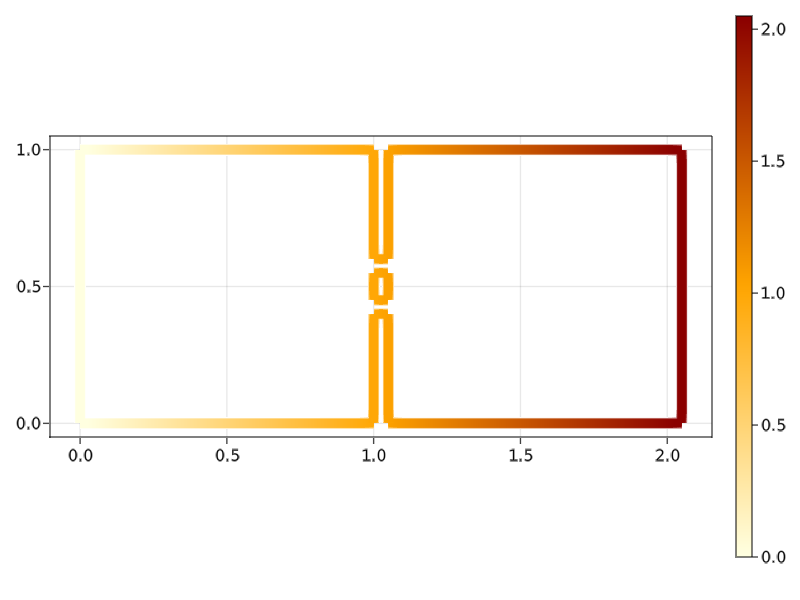

In [ ]:
ue(x)=x[1]
Γ₁ = BoundaryTriangulation(model,tags=["ext", "int"])
fig, ax , plt  = plot(Γ₁,ue, colormap=:heat, linewidth=10)
ax.aspect = AxisAspect(2.2)
Colorbar(fig[1,2], plt)
fig

#plot(Γ₁)

In [ ]:
#scatter(BoundaryTriangulation(model,tags=[4]))


In [ ]:
reffe = ReferenceFE(lagrangian,Float64,order)

(Lagrangian(), (Float64, 2), Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [ ]:
V = TestFESpace(model,reffe,dirichlet_tags=dirichlet_tags,conformity=:H1,vector_type=Vector{ComplexF64})
U = TrialFESpace(V,0.0)

TrialFESpace()

In [ ]:
#ls = LUSolver()
#solver = LinearFESolver(ls)

In [ ]:
norm_L2(u) = sqrt(real(sum(∫(u'*u)*dΩₕ)))

norm_L2 (generic function with 1 method)

In [ ]:
function u_0_bump(x,par) 
    r0, r1, p = par
    r = sqrt((x[1]-0.5)^2 + (x[2]-0.5)^2)
    if r > r0 && r < r1
        return (r-r0)^p*(r-r1)^p * (4^(2p)) + 0.0*im
    else 
        return 0.0 + 0.0*im
    end
end

function u_0_particle(x,par)
    r0, xi, k, p = par
    r = sqrt((x[1]-xi[1])^2 + 0.2*(x[2]-xi[2])^2)
    kx = 2π*(k[1]*(x[1]-xi[1]) + k[2]*(x[2]-xi[2]))
    if r < r0
        return (r-r0)^p * 4^p *exp(im*kx)
    else 
        return 0.0 + 0.0*im
    end
end
        

par_particle = (0.2, [0.5;0.5], [-10;0], 2)

u_0_particle([0.5;0.5], par_particle)


0.6400000000000001 + 0.0im

In [ ]:
test=false
bump=false
particle=true


if test
    u_0(x) = u_0_test(x,par_test)
elseif bump
    u_0(x) = u_0_bump(x, par_bump)
elseif particle 
    u_0(x) = u_0_particle(x, par_particle)    
end

u_n = interpolate_everywhere(u_0,V)
#writevtk( Ωₕ,"Results/results_$(lpad(0,3,'0'))", cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])


SingleFieldFEFunction():
 num_cells: 185606
 DomainStyle: ReferenceDomain()
 Triangulation: UnstructuredGrid()
 Triangulation id: 14677597502317758768

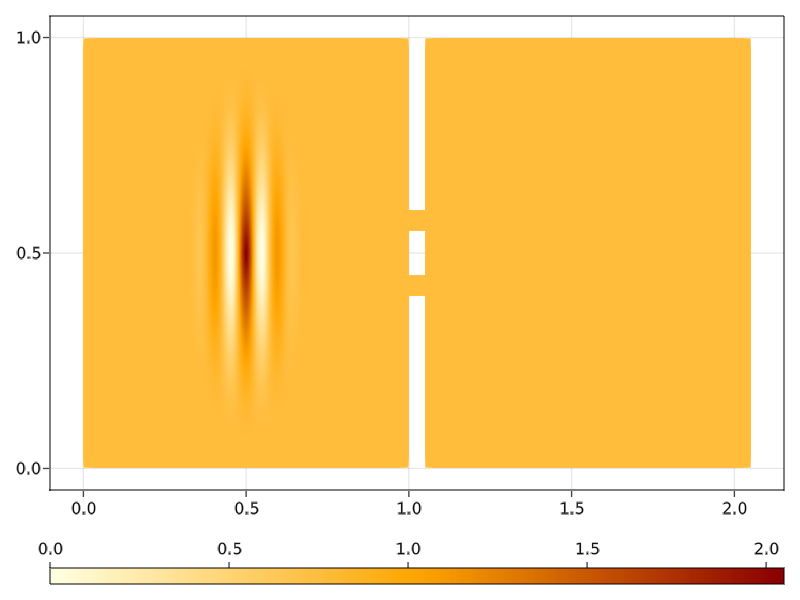

In [ ]:
fig, axₕlt = plot(Ωₕ, real(u_n), colormap=:heat)
ax.aspect = AxisAspect(2.2)
Colorbar(fig[2,1], plt, vertical=false)
current_figure()
#fig

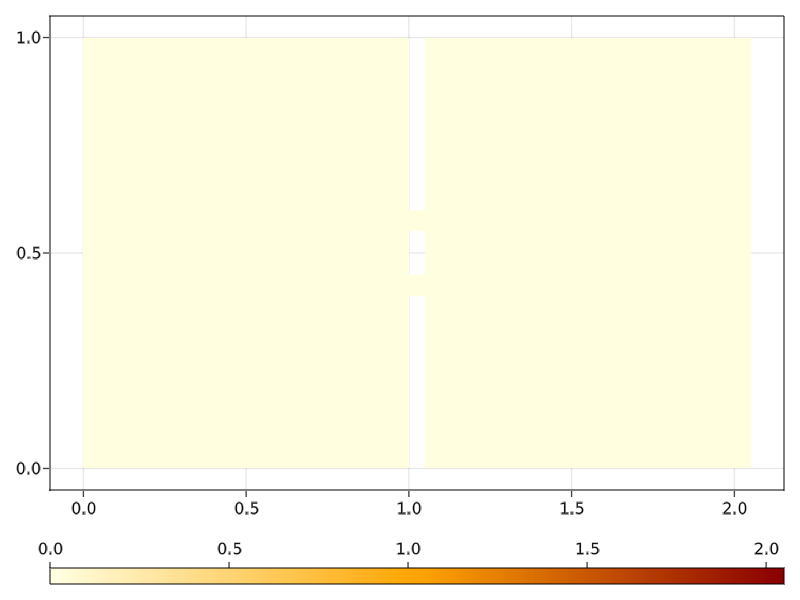

In [ ]:
function ϵ(x)
    l = Lx*0.1
    lx_0 = l
    lx_1 = 2*Lx + Sx - l
    ly_0 = l
    ly_1 = Ly - l
    if (x[1] < lx_0)
        return 1 - (x[1]/lx_0)^2
    elseif (x[2] < ly_0)
        return 1 - (x[2]/ly_0)^2
    elseif (x[1] > lx_1)
        return 1 - ((x[1] - (lx_1+l))/l)^2
    elseif (x[2] > ly_1)
        return 1 - ((x[2] - (ly_1+l))/l)^2
    else
        return 0.0 + im*0.0
    end
end

if dumping 
    ϵₕ = interpolate_everywhere(ϵ,V)
else
    ϵₕ = interpolate_everywhere(0.0,V)
end

fig, axₕlt = plot(Ωₕ, real(ϵₕ), colormap=:heat)
ax.aspect = AxisAspect(2.2)
Colorbar(fig[2,1], plt, vertical=false)
current_figure()

To generate just once the matrix A we follow this example: https://github.com/gridap/Gridap.jl/blob/master/test/FESpacesTests/AssemblersTests.jl



In [ ]:
assem = SparseMatrixAssembler(U,V)
dv = get_fe_basis(V)
du = get_trial_fe_basis(U)



a(u,v) = ∫(((1 + im*ϵₕ))*(∇(v) ⋅ ∇(u))*dt + im*2*v*u)dΩₕ

mat_contribs = a(du,dv)
data = collect_cell_matrix(U,V,mat_contribs)
A = assemble_matrix(assem,data)

t = 0
u_n = interpolate_everywhere(u_0,V)
writevtk(
          Ωₕ,"Results/"*file_name*"_$(lpad(0,3,'0'))",
          cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])

if test
    e = zeros(num_steps ÷ n_int)
end
    
for istep in 1:num_steps

    #println("\n+++ Solving in step $istep of $num_steps +++\n")
    t = t+dt
    b(v) = ∫(((1 + im*ϵₕ))*(∇(v) ⋅ ∇(-u_n))*dt + im*2*v*u_n)dΩₕ
    vec_contribs = b(dv)
    data = collect_cell_vector(V,vec_contribs)
    b = assemble_vector(assem,data)
    
    #op = AffineFEOperator(a,b,U,V)
    #uh = solve(solver,op)
    x = A\b
    uh = FEFunction(U,x)
    
    u_n = uh
    
    if (istep-1) % n_int == 0 && istep > 1
        writevtk(
          Ωₕ,"Results/"*file_name*"_$(lpad(istep,3,'0'))",
          cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])
        l2 = norm_L2(u_n)
        println("time = $t,      l2 = $l2")
        if test 
            u_0(x) = test_solution(x,t,par_test)
            u_s = interpolate_everywhere(u_0,V)
            error = norm_L2(u_n - u_s)
            e[(istep-1) ÷ n_int] = error
            l2 = norm_L2(u_n)
            println("time = $t, rel_error = $(error/l2),      l2 = $l2")
        end
    end
        

end


time = 0.006,      l2 = 0.08759486637726673
time = 0.011000000000000003,      l2 = 0.08759486637726527
time = 0.016000000000000007,      l2 = 0.08759486637726545
time = 0.02100000000000001,      l2 = 0.08759486637726782
time = 0.026000000000000016,      l2 = 0.08759486637726807
time = 0.03100000000000002,      l2 = 0.08759486637726945
time = 0.036000000000000025,      l2 = 0.08759486637726963
time = 0.04100000000000003,      l2 = 0.08759486637726904
time = 0.046000000000000034,      l2 = 0.08759486637726954
time = 0.05100000000000004,      l2 = 0.08759486637726938
time = 0.05600000000000004,      l2 = 0.0875948663772696
time = 0.06100000000000005,      l2 = 0.08759486637727022
time = 0.06600000000000004,      l2 = 0.08759486637726997
time = 0.07100000000000005,      l2 = 0.08759486637726997
time = 0.07600000000000005,      l2 = 0.08759486637727082
time = 0.08100000000000006,      l2 = 0.08759486637727168
time = 0.08600000000000006,      l2 = 0.08759486637727085
time = 0.091000000000000